In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.tseries.offsets import BDay
from dotenv import load_dotenv


In [3]:
# Read in environment variables
load_dotenv()

# Save OPENAI's API key
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [4]:
# Define data folder
data_folder = Path.cwd().parent / 'data'

# Read in transaction data
transactions_df = pd.read_csv(data_folder / "transactions/categorized_transactions.csv")

In [5]:
def get_actual_payday(year, month):
    """
    Determines the actual payday for a given month.
    - If the 26th is a weekend/holiday, shifts payday to the previous business day.
    
    Returns: Adjusted payday as a datetime object.
    """
    payday = pd.Timestamp(year, month, 26)
    
    # If payday falls on a weekend, shift to the previous business day
    if payday.weekday() >= 5:  # 5=Saturday, 6=Sunday
        payday -= BDay(1)  # Move to the previous business day

    return payday

In [6]:
def assign_pay_period(df, date_column="Date"):
    """
    Assigns transactions to the correct pay period based on the adjusted payday.
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format

    # Determine pay periods
    df["PayPeriod"] = df[date_column].apply(
    lambda x: get_actual_payday(x.year - 1, 12).strftime('%Y-%m')
    if x.month == 1 else get_actual_payday(x.year, x.month - 1).strftime('%Y-%m')
    )

    return df

In [7]:
# Add Pay Period column
transactions_df = assign_pay_period(transactions_df)

In [8]:
def transaction_pay_period(df):
    # Get the min and max date of the transactions dataframe
    min_date = df['Date'].min() - pd.offsets.MonthEnd(1)
    max_date = df['Date'].max() + pd.offsets.MonthEnd(1)

    # Get the monthly date range between min and max date
    date_range = pd.date_range(
        start = min_date,
        end = max_date,
        freq = 'ME'
    )

    # Initialize column to store pay period month
    df['Pay_Period'] = None

    # Get the pay period ranges for each month
    for x in date_range:
      
        current_paydate = get_actual_payday(x.year, x.month)
        if x.month == 12:
            next_paydate = get_actual_payday(x.year + 1, 1)
        else:
            next_paydate = get_actual_payday(x.year, x.month + 1)

        pay_period_range = pd.date_range(
            start = current_paydate,
            end = next_paydate,
            freq = 'D',
            inclusive = 'left'
        )

        # If the transaction falls within the pay period's date range, mark it as the correct month's pay period
        df['Pay_Period'] = df.apply(
            lambda x: (current_paydate + pd.DateOffset(months=1)).strftime('%B %Y') if x['Date'] in pay_period_range
            else x['Pay_Period'],
            axis=1
        )
        
    return df

In [9]:
transactions_df = transaction_pay_period(transactions_df)

In [10]:
def classify_income_expense(df, amount_column = 'Amount'):
    df['Transaction_Type'] = df[amount_column].apply(
        lambda x: 'Income' if x >= 0
        else 'Expense'
    )
    return df

In [11]:
transactions_df = classify_income_expense(transactions_df)

In [12]:
def classify_savings(df, description_column='Description', type_column='Transaction_Type'):
    df.loc[df['Description'].str.lower().str.contains('6031'),'Transaction_Type'] = 'Savings'
    df.loc[df['Transaction_Type'] == 'Savings','Amount'] *=-1

    return df

In [13]:
transactions_df = classify_savings(transactions_df)

In [14]:
def get_current_pay_period(df):   
    # Identify the current pay period
    current_pay_period = df[df['Pay_Period'] == 'March 2025']
    current_pay_period = current_pay_period[~((current_pay_period['Transaction_Type'] == 'Income') & (current_pay_period['Bank'] == 'AMEX'))]

    # Build helper columns for identifying refund transactions
    current_pay_period['abs_amount'] = current_pay_period['Amount'].abs()
    current_pay_period['is_refund_pair'] = False

    # Group transactions by absolute amount and check for charge-refund pairs
    matched_indices = set()
    for amount, group in current_pay_period.groupby('abs_amount'):
        charges = group[group['Amount'] < 0]
        refunds = group[group['Amount'] > 0]
        
        # Create empty list for storing paired indexes
        refund_exclude_list = []

        # Pair each charge with a refund within a close date range
        for charge_idx, charge_row in charges.iterrows():
            for refund_idx, refund_row in refunds.iterrows():
                if (abs((charge_row['Date'] - refund_row['Date']).days) <= 3) and refund_idx not in refund_exclude_list:  # Allow a 3-day window
                    current_pay_period.at[charge_idx, 'is_refund_pair'] = True
                    current_pay_period.at[refund_idx, 'is_refund_pair'] = True
                    refund_exclude_list.append(refund_idx)
                    break  # Move to next charge

    # Mark refund pairs as Ignored Transaction Type
    current_pay_period['Transaction_Type'] = current_pay_period.apply(
        lambda row: 'Ignored' if row['is_refund_pair'] == True
        else row['Transaction_Type'],
        axis=1
    )

    # Get the current pay period income
    current_pay_period_income = current_pay_period.groupby('Transaction_Type')['Amount'].sum()['Income']
    current_pay_period_expenses = current_pay_period.groupby('Transaction_Type')['Amount'].sum()['Expense']

    return current_pay_period, current_pay_period_income, current_pay_period_expenses

In [15]:
current = get_current_pay_period(transactions_df)[0]

In [16]:
current.groupby('Transaction_Type')['Amount'].sum()

Transaction_Type
Expense   -2216.78
Income     8780.25
Savings    3200.00
Name: Amount, dtype: float64

In [17]:
get_current_pay_period(transactions_df)[2]

np.float64(-2216.78)

In [18]:
transactions_df = classify_income_expense(transactions_df)

In [19]:
current_pay_period = get_current_pay_period(transactions_df)[0]
current_income = get_current_pay_period(transactions_df)[1]
current_expense_amount = get_current_pay_period(transactions_df)[2]

In [20]:
fig = plot_expense_by_category(current_pay_period)

NameError: name 'plot_expense_by_category' is not defined

In [ ]:
def plot_expense_by_category(df):
    current_expenses = df[df['Transaction_Type'] == 'Expense']
    current_expenses['abs_amount'] = current_expenses['Amount'].abs()

    expense_by_category = current_expenses.groupby('Category')['abs_amount'].sum().reset_index()
    expense_by_category = expense_by_category[expense_by_category['Category'] != 'Savings']
    expense_by_category = expense_by_category.sort_values(by='abs_amount', ascending=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10,6))

    # Create horizontal bar plot
    ax.barh(expense_by_category['Category'], expense_by_category['abs_amount'], color='royalblue')

    # Add labels and title
    ax.set_xlabel('Expenses ($)')
    ax.set_ylabel('Category')
    ax.set_title('Monthly Expenses by Category')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    return fig


In [ ]:
def cash_flow_plot(df):
    # Format columns
    df['Date'] = pd.to_datetime(df['Date'])
    df['YearMonth'] = df['Date'].dt.to_period("M")

    # Aggregate monthly cash flow
    net_savings = df.groupby("YearMonth")["Amount"].sum().reset_index()

    # Create cash flow plot
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(net_savings["YearMonth"].astype(str), net_savings["Amount"], linestyle="-")

    return fig

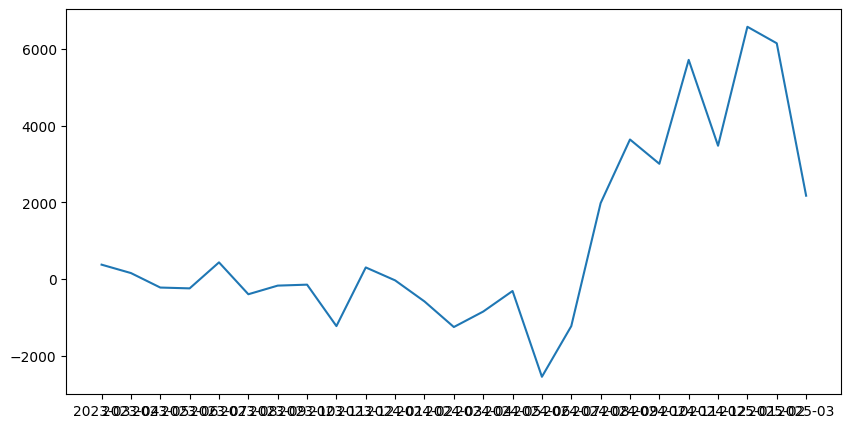

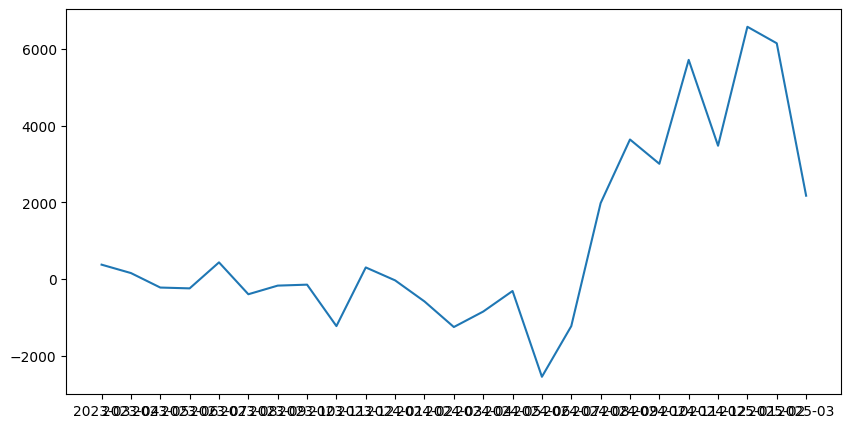

In [ ]:
cash_flow_plot(transactions_df)

In [ ]:
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'])

In [ ]:
transactions_df['YearMonth'] = transactions_df['Date'].dt.to_period("M")

In [ ]:
# Aggregate monthly spending
net_savings = transactions_df.groupby("YearMonth")["Amount"].sum().reset_index()

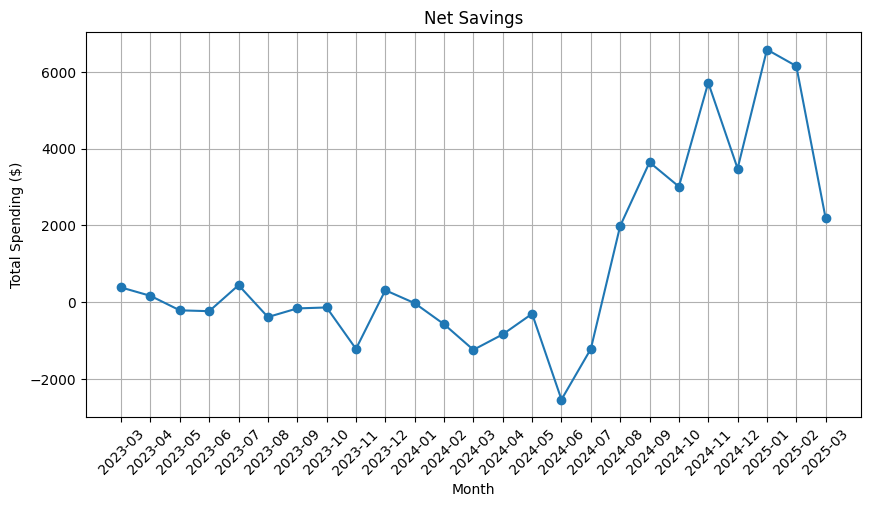

In [ ]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(net_savings["YearMonth"].astype(str), net_savings["Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Total Spending ($)")
plt.title("Net Savings")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [ ]:
def classify_expense_income(amount):
    if amount < 0:
        type_of_transaction = 'Expense'
    elif amount > 0:
        type_of_transaction = "Income"
    else:
        type_of_transaction = "Neutral"
    
    return type_of_transaction

In [ ]:
transactions_df['Transaction_Type'] = transactions_df.apply(lambda row: classify_expense_income(amount=row["Amount"]), axis=1)

In [ ]:
transactions_df['Abs_Amount'] = abs(transactions_df['Amount'])

In [ ]:
# Create dataframe for expenses
expenses_df = transactions_df[transactions_df['Transaction_Type'] == 'Expense']

# Create dataframe for income transactions
income_df = transactions_df[transactions_df['Transaction_Type'] == 'Income']

In [ ]:
# Aggregate monthly spending
monthly_spending = expenses_df.groupby("YearMonth")["Abs_Amount"].sum().reset_index()

In [ ]:
# Aggregate monthly income
monthly_income = income_df.groupby("YearMonth")["Amount"].sum().reset_index()

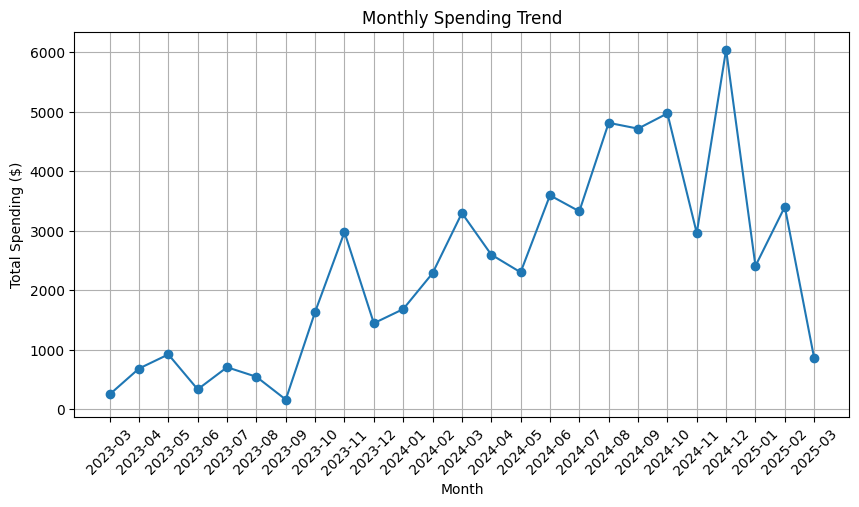

In [ ]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(monthly_spending["YearMonth"].astype(str), monthly_spending["Abs_Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Total Spending ($)")
plt.title("Monthly Spending Trend")
plt.xticks(rotation=45)
plt.grid()
plt.show()

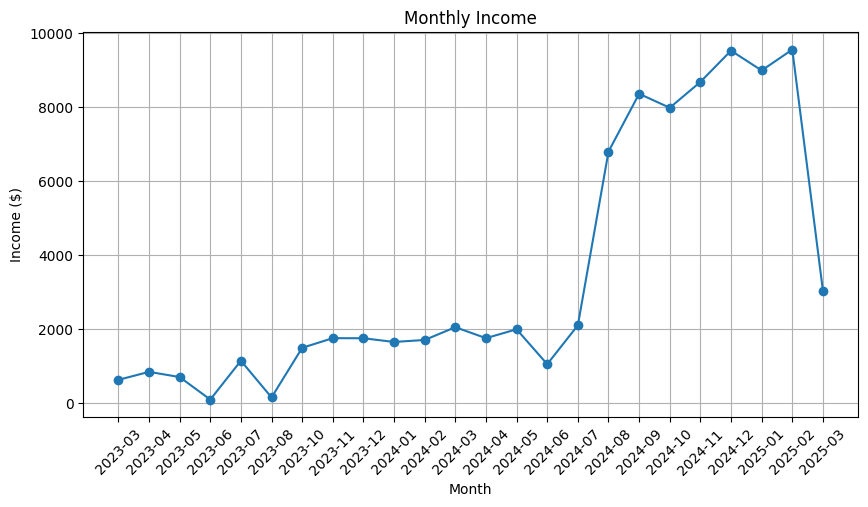

In [ ]:
# Plot monthly spending
plt.figure(figsize=(10, 5))
plt.plot(monthly_income["YearMonth"].astype(str), monthly_income["Amount"], marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("Income ($)")
plt.title("Monthly Income")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
# Aggregate income vs expense
income_expense = transactions_df.groupby(["YearMonth", "Transaction_Type"])["Abs_Amount"].sum().unstack().fillna(0)

In [ ]:
income_expense

Transaction_Type,Expense,Income
YearMonth,,
2023-03,253.09,632.86
2023-04,687.98,848.78
2023-05,925.37,708.45
2023-06,338.35,100.00
2023-07,710.04,1149.38
2023-08,549.44,157.91
2023-09,166.61,0.00
2023-10,1639.84,1498.43
2023-11,2980.65,1759.08


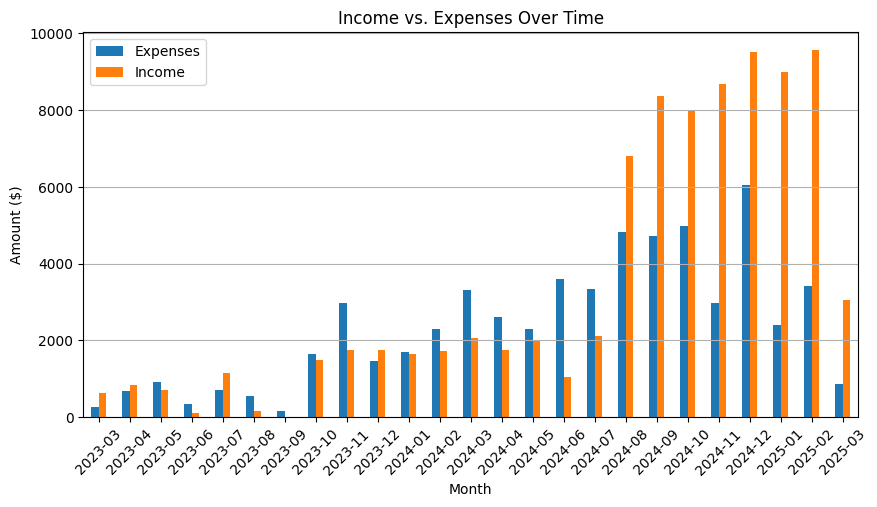

In [ ]:
# Plot bar chart
income_expense.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Month")
plt.ylabel("Amount ($)")
plt.title("Income vs. Expenses Over Time")
plt.xticks(rotation=45)
plt.legend(["Expenses", "Income"])
plt.grid(axis="y")
plt.show()

In [ ]:
amex_transactions = transactions_df[transactions_df['Bank'] == 'AMEX']

In [ ]:
total_car_lease = 14364
nss_total_amount = 8625

In [ ]:
total_car_lease_paid = expenses_df[expenses_df['Description'].str.contains("CHRYSLER CAPITAL")]['Amount'].sum()
nss_total_paid = transactions_df[transactions_df['Description'].str.contains("NASHVILLE SOFTWARE")]['Amount'].sum()
car_lease_balance = round((total_car_lease + total_car_lease_paid),2)
credit_card_balance = round(amex_transactions['Amount'].sum(),2)
nss_school_balance = (nss_total_amount + nss_total_paid)

In [ ]:
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
SOURCE_DIR = BASE_DIR / 'src'

In [ ]:
sys.path.append(str(BASE_DIR))

In [ ]:
sys.path

['C:\\Users\\kidsa\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'C:\\Users\\kidsa\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'C:\\Users\\kidsa\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'C:\\Users\\kidsa\\AppData\\Local\\Programs\\Python\\Python310',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects\\expense_dashboard\\.venv',
 '',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects\\expense_dashboard\\.venv\\lib\\site-packages',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects\\expense_dashboard\\.venv\\lib\\site-packages\\win32',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects\\expense_dashboard\\.venv\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects\\expense_dashboard\\.venv\\lib\\site-packages\\Pythonwin',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects\\mlops-projects',
 'c:\\Users\\kidsa\\OneDrive\\Documents\\Projects',
 'c:\

In [ ]:
transactions_df.columns

Index(['Date', 'Description', 'Amount', 'Transaction_ID', 'Bank', 'Category',
       'PayPeriod', 'Pay_Period', 'Transaction_Type', 'YearMonth',
       'Abs_Amount'],
      dtype='object')

In [ ]:
selected_column = 'Category'

In [ ]:
transactions_df['Category'].unique()

array(['Miscellaneous', 'Dining Out', 'Groceries', 'Subscriptions',
       'Shopping', 'Bills/Utilities', 'Gas', 'Entertainment',
       'Personal Care/Grooming', 'Car Payment', 'Savings',
       'Transportation', 'Education/Project', 'Insurance'], dtype=object)

In [ ]:
filtered_df = transactions_df[transactions_df[selected_column].str.lower().str.contains('dinin', na=False)]

In [ ]:
for column in transactions_df.columns:
    transactions_df[column] = transactions_df[column].astype(str)

In [ ]:
transactions_df['Category'].str.lower().str.contains(search_query, na=False).index

RangeIndex(start=0, stop=1099, step=1)

In [ ]:
# match_indices = set()

# search_query = 'DINING'
# search_query = search_query.lower()

# for column in transactions_df.columns:
#     list_of_indexes = transactions_df[transactions_df[column].str.lower().str.contains(search_query, na=False)].index
#     match_indices.update(list_of_indexes)
    
# list_of_indexes = list(match_indices)

# transactions_df.iloc[list_of_indexes].sort_values(by='Date', ascending=False)

In [ ]:
def transaction_filter(search_query, df):
    match_indices = set()
    
    search_query = search_query.lower()

    for column in df.columns:
        list_of_indexes = df[df[column].str.lower().str.contains(search_query, na=False)].index
        match_indices.update(list_of_indexes)

    list_of_indexes = list(match_indices)

    df = df.iloc[list_of_indexes].sort_values(by='Date', ascending=False)

    return df

In [ ]:
reports_folder = data_folder / 'reports'

In [ ]:
PERMANENT_OVERRIDES_FILE = reports_folder / 'category_dict.json'
ONE_OFF_CHANGES_FILE = reports_folder / 'category_one_off_changes.json'

In [ ]:
with open(PERMANENT_OVERRIDES_FILE, 'r') as file:
    test_df = json.load(file)

In [ ]:
list = transactions_df['Category'].unique().tolist()

In [ ]:
list.remove('Dining & Takeout')

ValueError: list.remove(x): x not in list

In [ ]:
x = str(Path.cwd().parent / 'data/reports/category_one_off_changes.json')
with open(x, 'r')as file:
    x_test = json.load(file)

In [ ]:
x_test['Category'] = 'Dinner'

In [ ]:
x_test

{'2607f40e-65b2-43a4-96b6-e69df8aadff6': 'Shopping',
 '30e08d27-e349-432a-9e85-92cac05f1ba7': 'Gas',
 'b5666ce0-86cf-4214-a8b7-342608bc05f5': 'Car Payment',
 '09ca771a-55af-4c70-ab27-4ad43a45a12d': 'Bills/Utilities',
 'Category': 'Dinner'}

In [ ]:
import json

In [ ]:
for file_path in [PERMANENT_OVERRIDES_FILE, ONE_OFF_CHANGES_FILE]:
    if not file_path.exists():
        file_path.write_text(json.dumps({}))

In [ ]:
import sys
BASE_DIR = Path.cwd().parent
sys.path.append(str(BASE_DIR))

In [ ]:
from src.budget_analysis import plot_expense_by_category

In [ ]:
transactions_df[transactions_df['Needs_Wants_Savings'].isnull()]['Category'].unique()

KeyError: 'Needs_Wants_Savings'

In [ ]:
def map_needs_wants_savings(df):
    new_df = df.copy()
    needs_wants_savings_mapping = {
        "Rent/Mortgage": "Needs",
        "Transportation": "Needs",
        "Gas": "Needs",
        "Car Payment":"Needs",
        "Personal Care/Grooming": "Wants",
        "Insurance": "Needs",
        "Groceries": "Needs",
        "Dining Out": "Wants",
        "Bills/Utilities": "Needs",
        "Debt Payments": "Savings",
        "Savings": "Savings",
        "Shopping": "Wants",
        "Entertainment": "Wants",
        "Subscriptions": "Wants",
        "Personal Care": "Needs",
        "Education/Project": "Needs",
        "Miscellaneous": "Wants"}

    new_df['Needs_Wants_Savings'] = new_df['Category'].map(needs_wants_savings_mapping)

    return new_df


In [ ]:
transactions_df = map_needs_wants_savings(transactions_df)

In [ ]:
from src.budget_analysis import assign_pay_period, transaction_pay_period, classify_income_expense, classify_savings

In [ ]:
def plot_fifty_thirty_twenty(df, remaining_balance):
    main_category_totals = df.groupby("Needs_Wants_Savings")['Amount'].sum()
    main_category_totals = main_category_totals.abs()
    main_category_totals['Remaining'] = remaining_balance

    # Define custom colors
    colors = ["#E57373", "#81C784", "#64B5F6", "#b0b0b0"]  # Add more colors as needed

    # Plot Pie Chart
    fig, ax = plt.subplots(figsize=(8,8))
    ax.pie(main_category_totals, labels=main_category_totals.index, autopct="%1.1f%%", startangle=140, colors=colors)
    ax.set_title("50/30/20 Budget")

    return fig

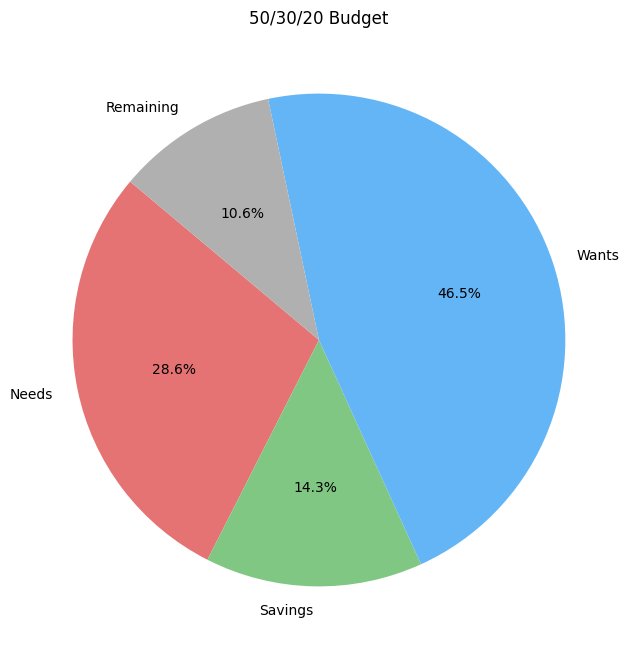

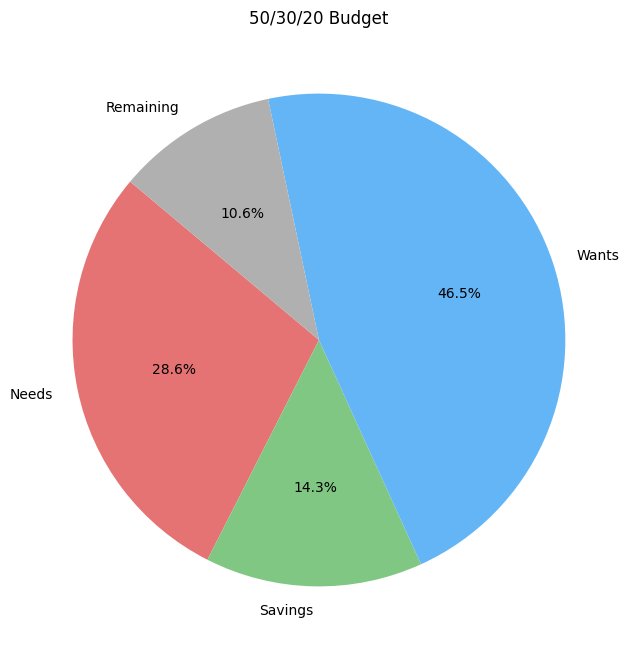

In [ ]:
plot_fifty_thirty_twenty(transactions_df, 10000)

In [46]:
import sys

In [48]:
Path.cwd().parents[0]

WindowsPath('c:/Users/kidsa/OneDrive/Documents/Projects/mlops-projects/expense_dashboard')

In [52]:
sys.path.append(Path.cwd().parents[1])

In [53]:
from src.budget_analysis import map_needs_wants_savings

ModuleNotFoundError: No module named 'src'

In [55]:
def map_needs_wants_savings(df):
    new_df = df.copy()
    needs_wants_savings_mapping = {
        "Rent/Mortgage": "Needs",
        "Transportation": "Needs",
        "Gas": "Needs",
        "Car Payment":"Needs",
        "Personal Care/Grooming": "Wants",
        "Insurance": "Needs",
        "Groceries": "Needs",
        "Dining Out": "Wants",
        "Bills/Utilities": "Needs",
        "Debt Payments": "Savings",
        "Savings": "Savings",
        "Shopping": "Wants",
        "Entertainment": "Wants",
        "Subscriptions": "Wants",
        "Personal Care": "Needs",
        "Education/Project": "Needs",
        "Miscellaneous": "Wants"}

    new_df['Needs_Wants_Savings'] = new_df['Category'].map(needs_wants_savings_mapping)

    return new_df

In [57]:
transactions_df = map_needs_wants_savings(transactions_df)

In [76]:
filtered_df['Amount'].sum()

np.float64(5268.379999999999)

In [58]:
selected_month = 'February 2025'
filtered_df = transactions_df[transactions_df['Pay_Period'] == selected_month]

In [123]:
income = filtered_df[(filtered_df['Transaction_Type'] == 'Income') & (filtered_df['Category'] != 'Savings') & (filtered_df['Bank'] != 'AMEX')]['Amount'].sum()
expenses = filtered_df[filtered_df['Transaction_Type'] != 'Income']
expense_amount = expenses['Amount'].sum()
savings = round(income + expense_amount, 2)

In [131]:
expenses.groupby('Needs_Wants_Savings')['Amount'].sum().abs()

Needs_Wants_Savings
Needs    1463.21
Wants    2259.01
Name: Amount, dtype: float64

In [132]:
expense_amount

np.float64(-3722.2200000000003)

In [68]:
filtered_df[filtered_df['Needs_Wants_Savings'] != 'Income']['Amount'].sum()

np.float64(5268.379999999999)

In [41]:
filtered_df[filtered_df['Transaction_Type'] != 'Income']['Amount'].sum()
filtered_df[filtered_df['Transaction_Type'] == 'Income']['Amount'].sum()

np.float64(8990.6)

In [ ]:
income = transactions_df[transactions_df['Transaction_Type'] == 'Income']['Amount'].sum()
expenses = transactions_df[transactions_df['Transaction_Type'] != 'Income']['Amount'].sum()

np.float64(83892.62999999999)

In [166]:
def plot_largest_expenses(original_df, selected_month):
    df = original_df.copy()
    expenses = df[df['Transaction_Type'] == 'Expense']
    expenses['abs_amount'] = expenses['Amount'].abs()
    expenses = expenses.sort_values(
        by='abs_amount',
        ascending=False
    )

    ten_largest_expenses = expenses[0:10].sort_values(
        by='abs_amount',
        ascending=True)

    fig, ax = plt.subplots(figsize=(8,8))

    categories = ten_largest_expenses['Description']
    values = ten_largest_expenses['abs_amount']

    ax.barh(categories, values)

    ax.set_label("Amount ($)")
    ax_set_ylabel("Description")
    ax.set_title(f"Largest Expenses for {selected_month}")
    return fig

- Create a visualization of categories over time
    - Add a dropdown for the user to choose category
    - Filter the dataframe for records with that category
    - Groupby Month Pay Period's month year (datetime format)
    - Plot the date on the x-axis
    - Plot the amount on the y-axis

C:\Users\kidsa\AppData\Local\Temp\ipykernel_37360\4134340055.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  filtered_df['Pay_Period_DT'] = pd.to_datetime(filtered_df['Pay_Period'])
C:\Users\kidsa\AppData\Local\Temp\ipykernel_37360\4134340055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Pay_Period_DT'] = pd.to_datetime(filtered_df['Pay_Period'])
C:\Users\kidsa\AppData\Local\Temp\ipykernel_37360\4134340055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

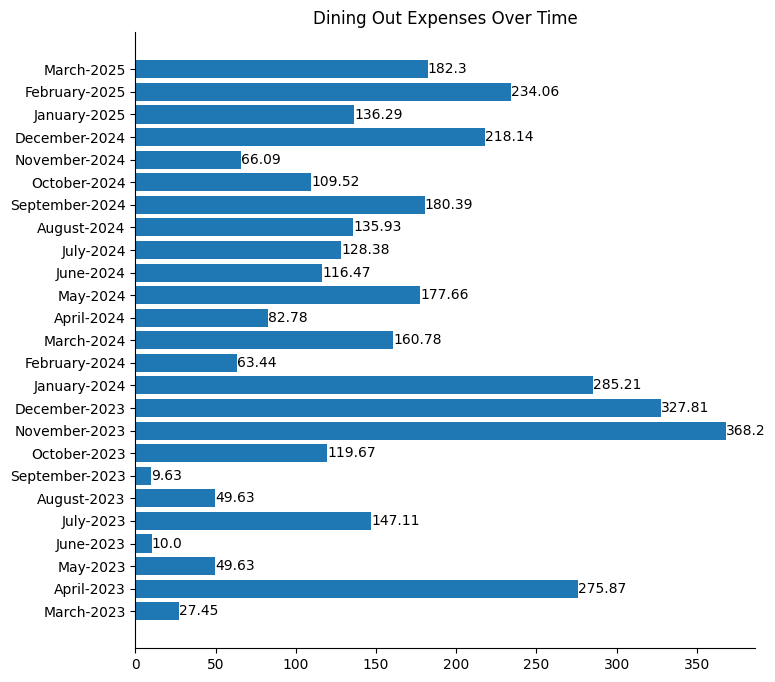

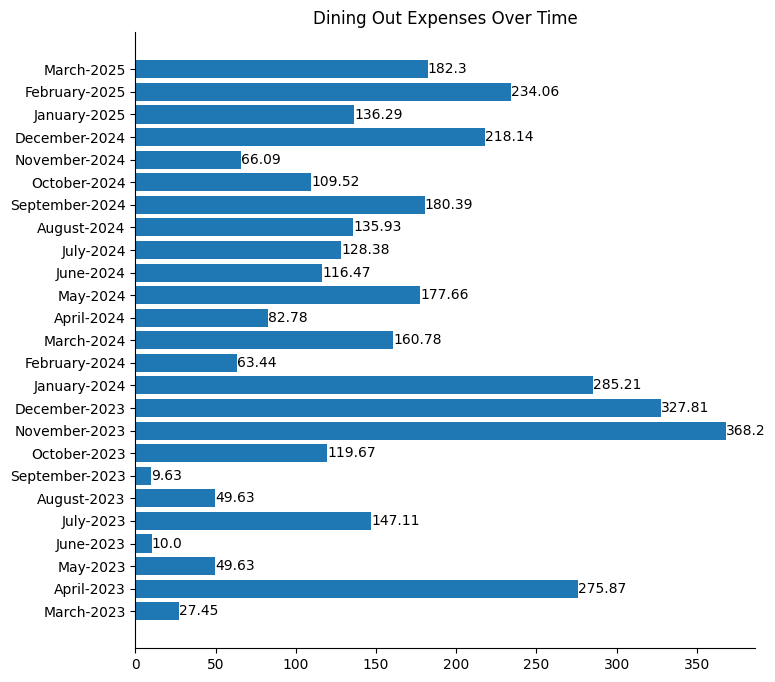

In [220]:
def plot_category_over_time(original_df, selected_category):
    df = original_df.copy()
    filtered_df = df[df['Category'] == selected_category]
    filtered_df['Pay_Period_DT'] = pd.to_datetime(filtered_df['Pay_Period'])
    filtered_df['abs_amount'] = filtered_df['Amount'].abs()
    
    monthly_category = filtered_df.groupby('Pay_Period_DT')['abs_amount'].sum().reset_index()
    monthly_category['Pay_Period_Month_Year'] = monthly_category['Pay_Period_DT'].dt.strftime("%B-%Y")
    months = monthly_category['Pay_Period_Month_Year']
    expenses = round(monthly_category['abs_amount'],2)

    fig, ax = plt.subplots(figsize=(8,8))

    # ax.plot(months, expenses)
    bars = ax.barh(months, expenses)

    # Add values to bars
    for bar in bars:
        xval = bar.get_width()
        ax.text(xval,
                bar.get_y() + bar.get_height()/2,
                f"{xval}",
                va="center", ha="left", fontsize=10
                )

    ax.set_title(f"{selected_category} Expenses Over Time")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.tick_params(axis='x', rotation=90)
    # ax.set_xticks(months)

    return fig

plot_category_over_time(transactions_df,'Dining Out')

In [189]:
dir(plt.subplots)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']